# Depression Survey Analysis

Author: Elijah Lopez

## Overview

This is a continuation of work from my [Exploratory Data Analysis Notebook](eda.ipynb) where I analyzed contributing factors to depression risk. In this notebook I tested various machine models across multiple performance metrics, highlighting the importance of 'Recall' for accurately classifiying at-risk individuals. After determining the best performing model, GridSearchCV was used to optimize performance. Finally, I created a Pipeline to efficiently and effectively preprocess survey data for future applications.

## Data

In [ ]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Machine Learning Preprocessing and Scoring Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [10]:
# Import Data
df = pd.read_csv('data/depression_data.csv')

### Null Values and Data Imputation

In the previous notebook we examined each of the null cases to ensure we can impute an appropriate value. We found that:
* Nulls in 'academic pressure' are attributed to non-students.
* Null in 'work pressure' are attributed to non-working professionals.
* Nulls in 'study satisfaction' are attributed to non-students.
* Nulls in 'job satisfaction' are attributed to non-working professionals.

Because of this we will impute:
* 1 for academic pressure, meaning that those that did not respond do not experience academic pressure.
* 1 for work pressure, meaning that those that did not respond do not experience work pressure.
* 3 for study satisfaction, meaning that those that did not respond will be neutral.
* 3 for job satisfaction, meaning that those that did not respond will be neutral.

In [11]:
# Drop ? from naming convention and replace spaces with underscores.
# Also make all columns lower case
df.columns = [column.replace(' ?', '').replace(' ', '_').lower() for column in df.columns]

df.drop(columns=['name'], inplace=True)

In [12]:
# Impute values as specified above
df.loc[:, 'academic_pressure'].fillna(1, inplace=True)
df.loc[:, 'work_pressure'].fillna(1, inplace=True)
df.loc[:, 'study_satisfaction'].fillna(3, inplace=True)
df.loc[:, 'job_satisfaction'].fillna(3, inplace=True)

# Check all values filled as expected
df.isna().sum()

gender                                    0
age                                       0
city                                      0
working_professional_or_student           0
profession                              673
academic_pressure                         0
work_pressure                             0
cgpa                                   2054
study_satisfaction                        0
job_satisfaction                          0
sleep_duration                            0
dietary_habits                            0
degree                                    0
have_you_ever_had_suicidal_thoughts       0
work/study_hours                          0
financial_stress                          0
family_history_of_mental_illness          0
depression                                0
dtype: int64

### Drop Columns

Neither Profession nor CGPA was statistically significant from our previous notebook. Both contain many null values with no clear best imputation strategy. For these reasons we will drop them from our predicitve model.

In [13]:
df.drop(columns=['profession', 'cgpa'], inplace=True)
df.head()

,gender,age,city,working_professional_or_student,academic_pressure,work_pressure,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,Female,37,Ghaziabad,Working Professional,1.0,2.0,3.0,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Male,60,Kalyan,Working Professional,1.0,4.0,3.0,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Female,42,Bhopal,Working Professional,1.0,2.0,3.0,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Female,44,Thane,Working Professional,1.0,3.0,3.0,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Male,48,Indore,Working Professional,1.0,4.0,3.0,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


### Encoding

At first glance it looks like we can encode:
* gender
* working_professional_or_student
* sleep_duration
* dietary_habits
* have_you_ever_had_suicidal_thoughts
* family_history_of_mental_illness
* depression

In [14]:
# Check current values
print(f"{df['gender'].value_counts()}\n")
print(f"{df['working_professional_or_student'].value_counts()}\n")
print(f"{df['sleep_duration'].value_counts()}\n")
print(f"{df['dietary_habits'].value_counts()}\n")
print(f"{df['have_you_ever_had_suicidal_thoughts'].value_counts()}\n")
print(f"{df['family_history_of_mental_illness'].value_counts()}\n")
print(f"{df['depression'].value_counts()}\n")

gender
Male      1333
Female    1223
Name: count, dtype: int64

working_professional_or_student
Working Professional    2054
Student                  502
Name: count, dtype: int64

sleep_duration
7-8 hours            658
Less than 5 hours    648
5-6 hours            628
More than 8 hours    622
Name: count, dtype: int64

dietary_habits
Unhealthy    882
Healthy      842
Moderate     832
Name: count, dtype: int64

have_you_ever_had_suicidal_thoughts
No     1307
Yes    1249
Name: count, dtype: int64

family_history_of_mental_illness
No     1311
Yes    1245
Name: count, dtype: int64

depression
No     2101
Yes     455
Name: count, dtype: int64



In [15]:
# Encode for model ingestion

# Gender
df.loc[:, 'gender'].replace({
    'Female': 0,
    'Male': 1
}, inplace=True)

# Working/Student
df.loc[:, 'working_professional_or_student'].replace({
    'Student': 0,
    'Working Professional': 1
}, inplace=True)

# Sleep Duration
df.loc[:, 'sleep_duration'].replace({
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3
}, inplace=True)

# Diet
df.loc[:, 'dietary_habits'].replace({
    'Unhealthy': 0,
    'Moderate': 1,
    'Healthy': 2
}, inplace=True)

# Previous thoughts of suicide
df.loc[:, 'have_you_ever_had_suicidal_thoughts'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Family History of Mental Illness
df.loc[:, 'family_history_of_mental_illness'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Depression
df.loc[:, 'depression'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               2556 non-null   int64  
 1   age                                  2556 non-null   int64  
 2   city                                 2556 non-null   object 
 3   working_professional_or_student      2556 non-null   int64  
 4   academic_pressure                    2556 non-null   float64
 5   work_pressure                        2556 non-null   float64
 6   study_satisfaction                   2556 non-null   float64
 7   job_satisfaction                     2556 non-null   float64
 8   sleep_duration                       2556 non-null   int64  
 9   dietary_habits                       2556 non-null   int64  
 10  degree                               2556 non-null   object 
 11  have_you_ever_had_suicidal_tho

In [16]:
# Isolate categorical columns
cat_cols = ['city', 'degree']

# One Hot Encode categorical columns
cat_df = df[cat_cols]
ohe = OneHotEncoder(drop='first', dtype=int, sparse_output=False)
ohe_data = ohe.fit_transform(cat_df)
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_df.columns))

# Merge encoded data frames together
full_df = pd.merge(df.drop(columns=cat_cols), ohe_df, left_index=True, right_index=True)

## Modeling

First we have to identify our predictors and target feature. Then we cna split them into training and testing groups.

In [17]:
# Split training and testing data
X = full_df.drop(columns='depression')
y = full_df['depression']

# Split into training and testing groups
# Stratified sampling maintains class distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y, random_state=50)

Now that our data is split we can perform scaling. Doing this after splitting ensures there is no data leakage between groups.

In [18]:
# Scale training and testing data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Baseline Performance

In oder to determine which model to develop further we can test many models at once using a function and assess their performance.

In [19]:
# Baseline Testing

def test_classification_models(X_train, y_train, cv=10, random_state=50):
    # Define Models to Test
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'XGBoost': XGBClassifier(random_state=random_state)
    }
    
    # Set Labels for future Data Frame
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],
        'ROC-AUC': []
    }
    
    # Test each Model and Record Results
    for model_name, model in models.items():
        cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
        results['Model'].append(model_name)
        results['Accuracy'].append(round(np.mean(cv_scores['test_accuracy']) * 100, 2))
        results['Precision'].append(round(np.mean(cv_scores['test_precision']) * 100, 2))
        results['Recall'].append(round(np.mean(cv_scores['test_recall']) * 100, 2))
        results['F1'].append(round(np.mean(cv_scores['test_f1']) * 100, 2))
        results['ROC-AUC'].append(round(np.mean(cv_scores['test_roc_auc']) * 100, 2))
    
    # Create Data Frame and Display
    results_df = pd.DataFrame(results)
    return results_df

In [20]:
# Call the function using our scaled data
test_classification_models(scaled_X_train, y_train)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,97.90,94.55,93.70,94.08,99.69
1,K-Nearest Neighbors,82.73,53.82,23.08,31.76,72.21
2,Decision Tree,90.75,73.79,74.70,74.18,84.46
3,Random Forest,93.69,92.09,70.85,79.81,97.67
4,Gradient Boosting,95.50,93.39,80.77,86.53,98.98
5,XGBoost,96.77,93.69,87.91,90.64,99.36


These results show that Logistic Regression is the best performing model in all measured areas. We can interpret the results as follows:
* `Accuracy`: This model correctly classifies 98% of all survey participants.
* `Precision`: When the model predicts that an individual is at risk, it is correct 95% of the time.
* `Recall`: Of all the at-risk individuals, the model correctly identifies 94% of them.
* `F1 Score`: The high value of 94% indicates a strong balance between correctly identifying at-risk individuals and minimizing false groupings.
* `ROC-AUC`: At >99% this model is performing exceptionally well -- differentiating between groups almost perfectly.

Because our goal is to support medical professionals in indentifying individuals at risk of depression, we want to minimize our false negative rate. This should put more emphasis into Recall as our metric of evaluation. Logistic Regression is the clear winner in this area so let's see if we can perform some hyperparameter tuning in order to improve our current performance.

### Optimize with GridSearchCV

In [21]:
# Specify parameters
params = {
    'C': [0.1, 1, 10, 100],             # Regularization Strength balances overfitting and underfitting
    'penalty': ['l2'],                  # Ridge maintains all features but penalizes large coefficients
    'solver': ['lbfgs', 'saga']         # Algorithm for optimization
}

# Increased max_iter due to convergence error
log_reg = LogisticRegression(max_iter=10000, random_state=50)

# Pass to GridSearchCV and print best recall score
gs = GridSearchCV(log_reg, params, cv=5, scoring='recall').fit(scaled_X_train, y_train)
print(gs.best_score_)

0.9505707762557076


With the GridSearchCV we are seeing slightly improved performance on recall. Let's see how well our model generalizes to unseen data by evaluating it against our test set.

### Test Performance

In [22]:
y_pred = gs.best_estimator_.predict(scaled_X_test)

results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC-AUC': []
}

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1'].append(f1)
results['ROC-AUC'].append(roc_auc)

pd.DataFrame(results)

,Accuracy,Precision,Recall,F1,ROC-AUC
0,0.986328,0.956522,0.967033,0.961749,0.978766


Yes! We are seeing a comparable performance on our test set, indicating that our model is not overfit or underfit. 'Recall' measures how good our model is at finding all the individuals who are truly at risk for depression. A recall score of 97% means that if there are 100 people who are actually at risk, our model successfully identifies about 97 of them. This is important because it minimizes the chances of missing someone who might need help. In healthcare, it's crucial to catch as many at-risk individuals as possible so that we can provide timely support and intervention.

### Visualization

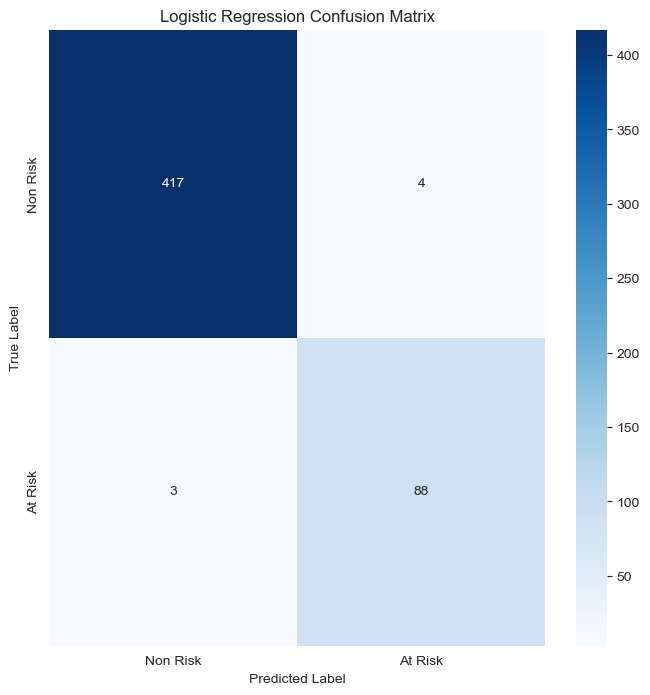

In [23]:
# Create confusion matrix and define labels for visual
cm = confusion_matrix(y_test, y_pred)
labels = ['Non Risk', 'At Risk']

# Format and visualize
figure = plt.subplots(figsize=(8,8))
sns.heatmap(cm,
            annot=True,
            cmap='Blues',
            fmt='.0f',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show();

## Feature Importance

Let's try to better understand how each factor contributes to risk of depression.

In [108]:
# Get feature names
feature_names = X_train.columns

# Extract coefficients
coefficients = gs.best_estimator_.coef_[0]

# Create DataFrame
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Isoloate highest impact features based on absolute value of coefficient
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# Choose top 10 and reoder by coefficient
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)[0:10]
coef_df = coef_df.sort_values(by='abs_coefficient')

coef_df

,feature,coefficient,abs_coefficient
12,family_history_of_mental_illness,3.136658,3.136658
7,sleep_duration,-3.729545,3.729545
8,dietary_habits,-3.831043,3.831043
10,work/study_hours,6.143213,6.143213
11,financial_stress,7.360613,7.360613
6,job_satisfaction,-8.773801,8.773801
3,academic_pressure,8.810594,8.810594
4,work_pressure,10.231989,10.231989
9,have_you_ever_had_suicidal_thoughts,12.683040,12.683040
1,age,-20.364951,20.364951


Next we can visualize these factors to see which have the highest impact and if they positively or negatively affect depression risk.

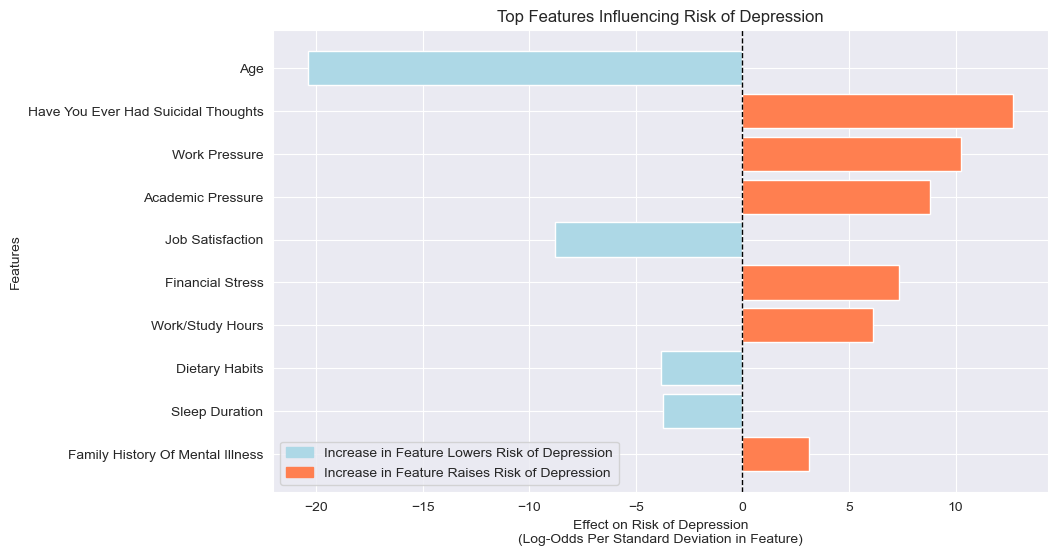

In [111]:
plt.figure(figsize=(10, 6))

# Data
x = [feature.replace('_', ' ').title() for feature in coef_df['feature']]
y = coef_df['coefficient']

colors = ['lightblue' if coef < 0 else 'coral' for coef in y]
plt.barh(x, y, color=colors)

# Labels
plt.title('Top Features Influencing Risk of Depression')
plt.xlabel(f'Effect on Risk of Depression\n(Log-Odds Per Standard Deviation in Feature)')
plt.ylabel('Features')

# Reference Line
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot with legend
legend_labels = [Patch(color='lightblue', label='Increase in Feature Lowers Risk of Depression'),
                 Patch(color='coral', label='Increase in Feature Raises Risk of Depression')]
plt.legend(handles=legend_labels)
plt.show();

## Pipeline Refactorization

We can more efficiently preprocess our data by refactoring our code above into functions and pass them into a pipeline. This makes it more scalable and readable.

Let's start by first turning the above code into functions.

In [ ]:
# Read in the data for fresh start
df = pd.read_csv('data/depression_data.csv')

# Pipeline Functions
# Clean Columns
def clean_columns(df):
    df = df.copy()
    df.columns = [column.replace(' ?', '').replace(' ', '_').lower() for column in df.columns]
    df.drop(columns=['name'], inplace=True)
    return df

# Impute Values
def impute_values(df):
    df = df.copy()
    df.loc[:, 'academic_pressure'].fillna(1, inplace=True)
    df.loc[:, 'work_pressure'].fillna(1, inplace=True)
    df.loc[:, 'study_satisfaction'].fillna(3, inplace=True)
    df.loc[:, 'job_satisfaction'].fillna(3, inplace=True)
    return df

# Drop Unnecessary Columns
def drop_columns(df):
    df = df.copy()
    df.drop(columns=['profession', 'cgpa'], inplace=True)
    return df

# Encode Values
def encode(df):
    df = df.copy()

    # Gender
    df.loc[:, 'gender'].replace({'Female': 0, 'Male': 1}, inplace=True)

    # Working/Student
    df.loc[:, 'working_professional_or_student'].replace({'Student': 0, 'Working Professional': 1}, inplace=True)

    # Sleep Duration
    df.loc[:, 'sleep_duration'].replace({
        'Less than 5 hours': 0,
        '5-6 hours': 1,
        '7-8 hours': 2,
        'More than 8 hours': 3
    }, inplace=True)

    # Diet
    df.loc[:, 'dietary_habits'].replace({
        'Unhealthy': 0,
        'Moderate': 1,
        'Healthy': 2
    }, inplace=True)

    # Previous thoughts of suicide
    df.loc[:, 'have_you_ever_had_suicidal_thoughts'].replace({'No': 0, 'Yes': 1}, inplace=True)

    # Family History of Mental Illness
    df.loc[:, 'family_history_of_mental_illness'].replace({'No': 0, 'Yes': 1}, inplace=True)

    return df

# One Hot Encode Categorical Features
def ohe(df):
    df = df.copy()

    # Isolate categorical columns
    cat_cols = ['city', 'degree']
    cat_df = df[cat_cols]

    # One Hot Encode categorical columns
    ohe = OneHotEncoder(drop='first', dtype=int, sparse_output=False)
    ohe_data = ohe.fit_transform(cat_df)
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_df.columns), index=df.index)

    # Merge encoded data frames together
    df = pd.merge(df.drop(columns=cat_cols), ohe_df, left_index=True, right_index=True)

    return df

Next we can create the pipeline. This will include each of the functions from above, a scaler to standardize the data, and our final estimator.

In [6]:
# Build Pipeline
pipe = Pipeline([
    ('cleaner', FunctionTransformer(clean_columns)),
    ('imputer', FunctionTransformer(impute_values)),
    ('droper', FunctionTransformer(drop_columns)),
    ('numeric_encoder', FunctionTransformer(encode)),
    ('one_hot_encoder', FunctionTransformer(ohe)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000, random_state=50))
])

We still need to split our data into training and testing sets. Additionally we need to relabel our target data. Let's do that now.

In [4]:
# Train Test Split
# Identify Features and Target Columns
X = df.drop(columns=['Depression'])
y = df['Depression']

# Adjust target labels to numeric
def adjust_target(y_data):
    y_data.replace({'No': 0, 'Yes': 1}, inplace=True)
    return y_data

y = adjust_target(y.copy())

# Split into training and testing groups
# Stratified sampling maintains class distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y, random_state=50)

In order to get the best model we will copy the Grid Search code from above.

In [7]:
# Specify parameters for Grid Search
params = {
    'classifier__C': [0.1, 1, 10, 100],             # Regularization Strength balances overfitting and underfitting
    'classifier__penalty': ['l2'],                  # Ridge maintains all features but penalizes large coefficients
    'classifier__solver': ['lbfgs', 'saga']         # Algorithm for optimization
}

gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='recall')

# Display pipeline
display(gs.fit(X_train, y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        FunctionTransformer(func=<function clean_columns at 0x0000016A75DCC280>)),
                                       ('imputer',
                                        FunctionTransformer(func=<function impute_values at 0x0000016A72742D30>)),
                                       ('droper',
                                        FunctionTransformer(func=<function drop_columns at 0x0000016A78BB9D30>)),
                                       ('numeric_encoder',
                                        FunctionTransformer(func=<function encode at 0x0000016A78BB9F70>)),
                                       ('one_hot_encoder',
                                        FunctionTransformer(func=<function ohe at 0x0000016A78C0F040>)),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=50))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['lbfgs', 'saga']},
             scoring='recall')

Here we see the steps of our pipeline.

The final step is to display our test results.

In [34]:
# Create Data Frame to display metrics of evaluation
y_pred = gs.best_estimator_.predict(X_test)

results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC-AUC': []
}

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1'].append(f1)
results['ROC-AUC'].append(roc_auc)

pd.DataFrame(results)

,Accuracy,Precision,Recall,F1,ROC-AUC
0,0.986328,0.956522,0.967033,0.961749,0.978766


These results match those from above, confirming that everything is working as intended.

## Results

Through data preprocessing, modeling, and optimization we were able to create a Logistic Regression model with a recall score of `95% on training data` and `97% on testing data`. This means that if there are 100 people who are actually at risk, our model successfully identifies about 95-97 of them. We found that age is the largest contributing factor to depression, having an inverse relationship. The top areas that can be actively modified to lower risk of depression include work and academic pressure, job satisfaction, and financial pressure.

## Next Steps

## Conclusion

By leveraging this machine model, medical professionals can more accurately identify individuals at risk of depression based on their survey responses. Proactive communciation with patients is of utmost importance to build trust, learn which factors are contributing most to their mental health, and to provide tailored recommendations to support their wellbeing. By understanding the contributing factors to depression, medical professionals can focus on holistic care and work collaboratively with patients to promote a healthly lifestyle. This includes:
* Establishing a positive work-life/student-life balance.
* Creating and maintaing a healthy diet.
* Abiding by a conducive sleep schedule.
* Offering resources for stress management.